
# 01 — LPT basics: painting and spectra

Build Gaussian initial conditions, run first-order LPT, paint flat/spherical maps, and inspect spectra using the library plot helpers.


In [1]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from fwd_model_tools import gaussian_initial_conditions
from fwd_model_tools.pm import lpt
from fwd_model_tools.pm.solvers import ReversibleSymplecticEuler

/home/wassim/Projects/NBody/jax_cosmo/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
ERROR:2025-12-11 10:01:29,634:jax._src.xla_bridge:477: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 475, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__in

In [2]:
# Tiny configuration for speed
key = jax.random.PRNGKey(0)
mesh_size = (256, 256, 256)
box_size = (5000.0, 5000.0, 5000.0)
nside = 256
flatsky_npix = (256, 256)
flat_field_size = (10, 10)
cosmo = jc.Planck15()

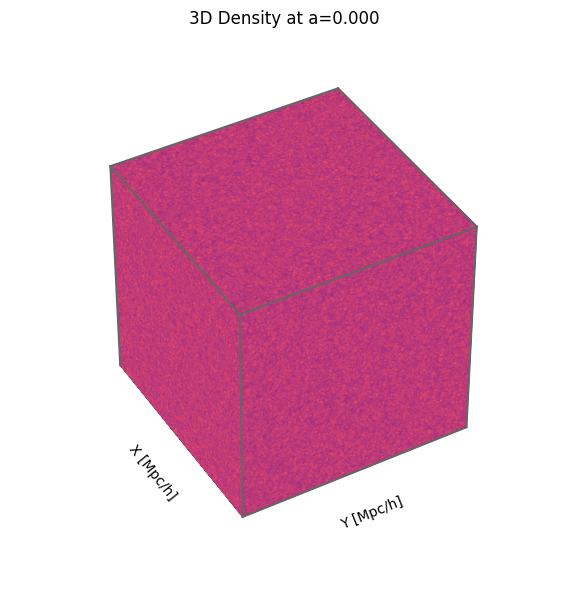

In [3]:
# 1) Gaussian initial field (pk_fn left None to use default)
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo, nside=nside, flatsky_npix=flatsky_npix, field_size=flat_field_size
)
initial_field.show(labels=["X [Mpc/h]", "Y [Mpc/h]", ""], colorbar=False)

In [4]:
from fwd_model_tools.pm.nbody import nbody

dx, p = lpt(cosmo, initial_field, scale_factor_spec=0.1, order=1, geometry="particles")
final_field = nbody(
    cosmo,
    dx_field=dx,
    p_field=p,
    dt0=0.2,
    nb_shells=6,
    geometry="spherical",
    solver=ReversibleSymplecticEuler(),
)

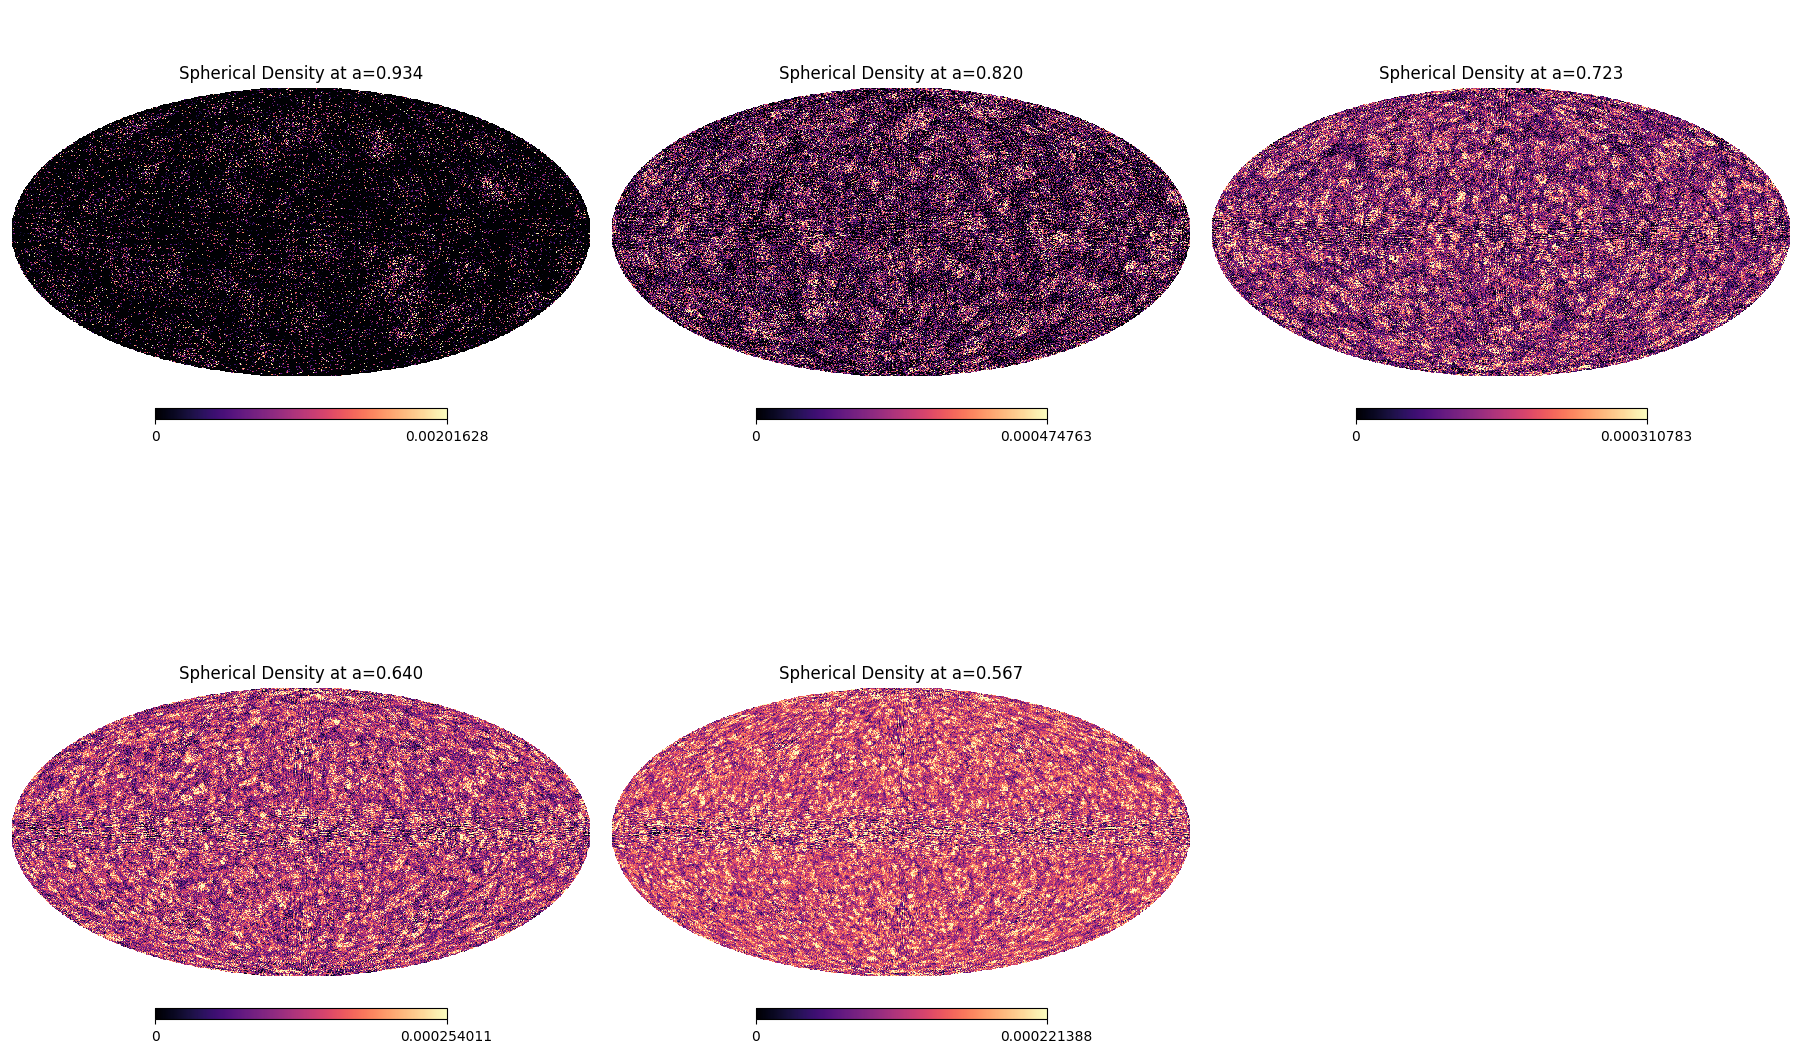

In [5]:
final_field.show()

z_centers = [0.2   0.511 0.821]


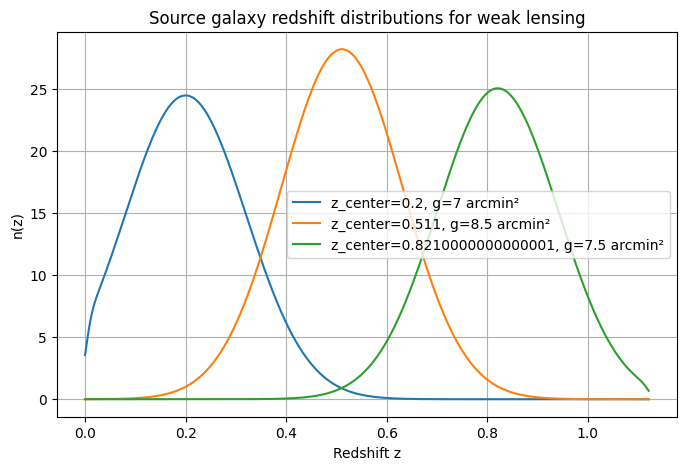

In [6]:
from fwd_model_tools.utils import compute_max_redshift_from_box_size
from scipy.stats import norm
import matplotlib.pyplot as plt

max_redshift = compute_max_redshift_from_box_size(cosmo, box_size , observer_position=final_field.observer_position)

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.3, 3)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5])
]

plt.figure(figsize=(8, 5))
z = jnp.linspace(0, max_redshift, 1000)
for i, nz in enumerate(nz_shear):
    plt.plot(z, nz(z) * nz.gals_per_arcmin2, label=f"z_center={z_centers[i]}, g={nz.gals_per_arcmin2} arcmin²")
plt.xlabel("Redshift z")
plt.ylabel("n(z)")
plt.title("Source galaxy redshift distributions for weak lensing")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_199067/1936115492.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


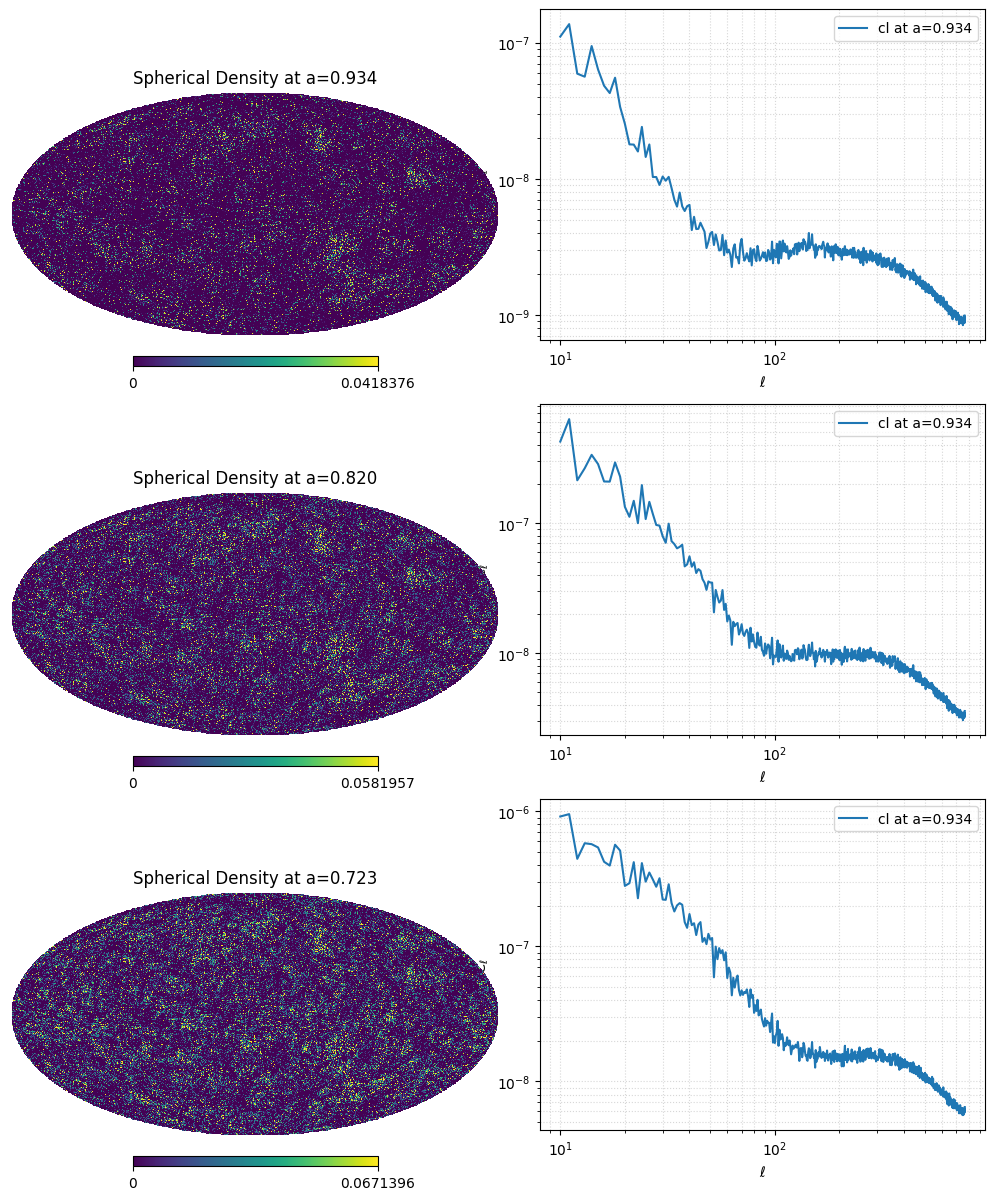

In [19]:
from fwd_model_tools.lensing import born

kappa_map = born(cosmo, lightcone=final_field, nz_shear=nz_shear)
cl = kappa_map.angular_cl(method="healpy")[: , 10:]

figure = plt.figure(figsize=(10, 12))
gs = figure.add_gridspec(3, 2 , width_ratios=[1, 1])
axes_maps = [figure.add_subplot(gs[i, 0]) for i in range(3)]
ax_cl = [figure.add_subplot(gs[i, 1]) for i in range(3)]

kappa_map.plot(cmap="viridis", ax=axes_maps)
cl[2].plot(ax=ax_cl[2] , logx=True , logy=True)
cl[1].plot(ax=ax_cl[1] , logx=True , logy=True)
cl[0].plot(ax=ax_cl[0] , logx=True , logy=True)

plt.tight_layout()
plt.show()